In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples.csv')
df.shape

CPU times: user 27.6 s, sys: 2.54 s, total: 30.1 s
Wall time: 30.1 s


(17937758, 9)

While attempting to train the model, it turned out that the reading and unpickling operation done at this scale, with so many files, is very computationally expensive.

But the examples in the mfcc represenatations are very small. Let's read them all into the memory before training.

In [3]:
# uniq_fns = np.unique(df.target_fn.values)

# %%time

# fn2feature = {}
# for fn in uniq_fns:
#     ary = pd.read_pickle(f'data/examples/{fn}.pkl')
#     fn2feature[fn] = ary

# pd.to_pickle(fn2feature, 'data/fn2feature.pkl')

In [4]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 16.6 s, sys: 10.9 s, total: 27.5 s
Wall time: 27.5 s


I suspect that reading the data from a file saved within numpy (`numpy.save`) is much less computationally expensive than unpickling it, but I might be wrong. Either way, at ~4 million of unique utterances, the dataset is small enough to comfortably fit within memory of a GCP instance (at ~53GBs used RAM during training).

This might not be ideal for experimentation on home rigs. Saving the data using `numpy.save` and evaluating performance would definitely be a very interesting and useful exercise.

In [5]:
df.head()

,source_word,target_word,source_fn,target_fn,set_name,speaker_id,book_id,distance_from_target,audio_fpath
0,I,FELT,43a14fe66b6348718f089ec553bf57b1,b6c1288c07504236a2b054c972a6e92f,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
1,I,THAT,43a14fe66b6348718f089ec553bf57b1,ed9ceac76f7e49e7809ec56db40d37a2,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
2,FELT,I,b6c1288c07504236a2b054c972a6e92f,43a14fe66b6348718f089ec553bf57b1,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
3,FELT,THAT,b6c1288c07504236a2b054c972a6e92f,ed9ceac76f7e49e7809ec56db40d37a2,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
4,FELT,IT,b6c1288c07504236a2b054c972a6e92f,235da027aeac418da43430e1f3470da4,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac


In [6]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

In [7]:
train_examples.size, valid_examples.size

(159688530, 1751292)

In [8]:
%%time

unique_fns = df.source_fn.unique()
np.random.shuffle(unique_fns)
lengths = []
for i, features in enumerate(fn2features.values()):
    lengths.append(features.shape[0])

CPU times: user 5.42 s, sys: 196 ms, total: 5.62 s
Wall time: 5.62 s


In [9]:
max(lengths)

291

In [10]:
np.mean(lengths)

29.028019713968394

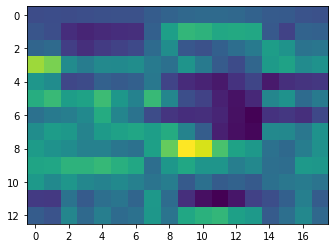

In [11]:
plt.imshow(features.T)

In [12]:
def prepare_features(fn, pad_to=max(lengths), pad_left=False):
    ary = fn2features[fn]
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [13]:
dss = Datasets(
    df,
    [lambda row: prepare_features(row.source_fn, pad_left=True),
     lambda row: prepare_features(row.target_fn),
     lambda row: prepare_features(row.target_fn)],
    n_inp=2,
    splits = [train_examples.index, valid_examples.index]
)

In [14]:
BS = 2048
LR = 1e-3
NUM_WORKERS = 10

train_dl = DataLoader(dss.train, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(dss.valid, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [15]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute `sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm`

In [16]:
teacher_forcing_ratio = 0

class Model(Module):
    def __init__(self, hidden_size=50):
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.decoder = nn.LSTM(
            input_size=13+hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        self.lin = nn.Linear(2*hidden_size, 13)
            
    def forward(self, source_features, target_features):
        _, (embeddings_dec, _) = self.encoder(source_features)
        embeddings_bi = torch.cat((embeddings_dec, embeddings_dec))
        embeddings_dec = embeddings_dec.permute(1,0,2)
        
        outputs = torch.zeros_like(target_features)
        input = target_features[:, :1, :]
        hidden = embeddings_bi
        cell = torch.zeros_like(embeddings_bi)
        for t in range(target_features.shape[1]):
            input = torch.cat((input, embeddings_dec), 2)
            x, (hidden, cell) = self.decoder(input, (hidden, cell))
            input = self.lin(x)
            outputs[:, t, :] = input.squeeze()
            
            if random.random() < teacher_forcing_ratio:
                input = target_features[:, t, :].unsqueeze(1)
        return outputs

In [17]:
# mse_loss = MSELoss()
# def modified_MSE(preds, targs):
#     mask = targs == 0
#     preds[mask] = 0
#     return mse_loss(preds, targs)

learn = Learner(dls.cuda(), Model().cuda(), loss_func=MSELoss(), lr=1e-3, opt_func=SGD)

In [18]:
learn.fit(16, cbs=SaveModelCallback(fname='16epochs_1e-3_SGD', every_epoch=True))

epoch,train_loss,valid_loss,time
0,25.405891,26.041719,1:19:12
1,24.271435,24.791180,1:20:08
2,23.041260,23.634680,1:20:46
3,22.733116,23.289080,1:22:18
4,22.438246,23.022280,1:23:30
5,22.109318,22.689079,1:22:14
6,21.932486,22.432524,1:21:57
7,21.707077,22.249060,1:22:17
8,21.510958,22.059782,1:22:22
9,21.411123,21.901356,1:22:17


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Calculate embedding for each unique word in the dataset

In [19]:
df_unique_utterances = df.drop_duplicates(['source_fn'])

In [20]:
dss_all_utterances = Datasets(
    df_unique_utterances,
    [lambda row: prepare_features(row.source_fn, pad_left=True), lambda row: 0],
    n_inp=2
)

In [21]:
all_dl = DataLoader(dss_all_utterances, BS, NUM_WORKERS)

In [22]:
%%time

all_embeddings = []
with torch.no_grad():
    learn.model.train = False
    for batch in all_dl:
        _, (embeddings, _) = learn.model.encoder(batch[0].cuda())
        all_embeddings.append(embeddings.squeeze(0).detach().cpu())

CPU times: user 44.9 s, sys: 20.3 s, total: 1min 5s
Wall time: 6min 36s


In [38]:
all_embeddings = torch.cat(all_embeddings)

In [23]:
df_unique_utterances.reset_index(drop=True, inplace=True)

In [39]:
%%time

word2row_idxs = defaultdict(lambda: list())

for idx, row in df_unique_utterances.iterrows():
    word2row_idxs[row.source_word].append(idx)
    
word2embedding = {}

for k, v in word2row_idxs.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0)

CPU times: user 6min 59s, sys: 1.22 s, total: 7min
Wall time: 6min 51s


In [40]:
word2embedding_without_nans= {}
nans_encountered = 0
for k, v in word2embedding.items():
    if k == k and (not np.isnan(v.numpy()).any()):
        word2embedding_without_nans[k] = v.numpy()
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

Encountered rows with nan values: 1


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [26]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [27]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [41]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [29]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116


In [42]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 242 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 49 words. Will replace them with mean vector
Missing 11 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.05025891129376428
Spearman correlation of scores on WS353 -0.024967348979964638
Spearman correlation of scores on SIMLEX999 -0.001284136642627865
